<div style='background-image: url("../../share/images/header.svg") ; padding: 0px ; background-size: cover ; border-radius: 5px ; height: 250px'>
    <div style="float: right ; margin: 50px ; padding: 20px ; background: rgba(255 , 255 , 255 , 0.7) ; width: 50% ; height: 150px">
        <div style="position: relative ; top: 50% ; transform: translatey(-50%)">
            <div style="font-size: xx-large ; font-weight: 900 ; color: rgba(0 , 0 , 0 , 0.8) ; line-height: 100%">Inverse Problems </div>
            <div style="font-size: large ; padding-top: 20px ; color: rgba(0 , 0 , 0 , 0.5)">Probabilistic inversion: Metropolis Algorithm </div>
        </div>
    </div>
</div>

##### Authors:
* Heiner Igel ([@heinerigel](https://github.com/heinerigel))

* Kilian Gessele ([@KGessele](https://github.com/KGessele))

* Berta Vilacís ([@bvilacis](https://github.com/bvilacis))

---


This notebook presents the sampling of a probability density function (pdf) using the Metropolis algorithm, a random walk with near neighbor sampling, a Monte Carlo method. 

The Monte Carlo methods are named after the city in the Monaco principality, because of the roulettes in the Casinos
(random number generator). The most common Monte Carlo sampling methods is the Metropolis sampler. The basic concept is to use random walks, a creation of a new random configuration for each step, to explore the probability density, making it go to the highest probability zones.


**Near neighbor sampling**

Given a set of points in space with a probability $p_i$ attached to every point $i$, we define random rules to select points such that the probability of selecting points is $p_i$. To avoid sampling the areas of low probability we introduce the concept of importance sampling. The near neigbor sampling limits the algorithm to walk in the neighborhood of the present point. 

The algorithm works as the following. At a given step, the random walker is at point $x_i$ for moving to another point $x_j$ we have to define rules. If we accept any random move the walker would sample the whole space. Instead of always accepting the transition, we reject the move sometimes. Let $f(x)$ be the probability density function:

 * if $f(x_j) \geqslant f(x_i)$ $\rightarrow$ accept the move
 * if $f(x_j) < f(x_i)$ $\rightarrow$ then decide randomly to move to $x_j$ with the probability of accepting the move: 
 $ P = \frac{f(x_j)}{f(x_i)}$ , 
 where P is the transition probability. 

After all the steps, we obtain the path of the walker, sampling all the arears where the probability density function has a higher value. 

In [1]:
# Import Libraries (PLEASE RUN THIS CODE FIRST!) 
# ----------------------------------------------
import numpy as np
import matplotlib
## Show Plot in The Notebook
matplotlib.use('nbagg')
import matplotlib.pyplot as plt
from IPython import display

from mpl_toolkits.mplot3d import Axes3D

**PARAMETER CONFIGURATION**

In this library the walker is allowed to move only within $20$% of the total size of the model space (neigh). In the case of allowing the algorithm to move on $100%$ of the model space we would retrieve the Metropolis sample algorithm. 

In [2]:
# Parameter Configuration
# ----------------------

# modified to look only in the near neighborhood

# Some global parameters
npp = 100000  #number of tries to take
ns = 300   # number of samples to keep 
neigh=0.20  #look only within 20% of the total size of the model space

**GENERATION OF THE PDF**

Monte Carlo sampling of a probability density function, in this case it is used the function "peaks" from Matlab. The corresponding section can simply be replaced with the probability from a proper inverse problem (e.g. hypocenter location)

In [3]:
# Generate a pdf

# the following steps generate a pdf; this is equivalent to the function "peaks(n)" in matlab
n = 100 # number of dimension
pdf = np.zeros( [n,n] )
x = -3.
for i in range(0,n):
    y = -3.
    for j in range(0,n):
        pdf[j,i]=3.*(1-x)**2*np.exp(-(x**2)-(y+1)**2)-10.*(x/5-x**3-y**5)*np.exp(-x**2-y**2)-1./3*np.exp(-(x+1)**2-y**2)
        if pdf[j,i] < 0:
            pdf[j,i] = pdf[j,i] * (-1) # in contrast to the peaks function: all negative values are multiplied by (-1)
        y = y + 6./(n-1)
    x = x + 6./(n-1)

pdf = pdf / pdf.sum()

<IPython.core.display.Javascript object>


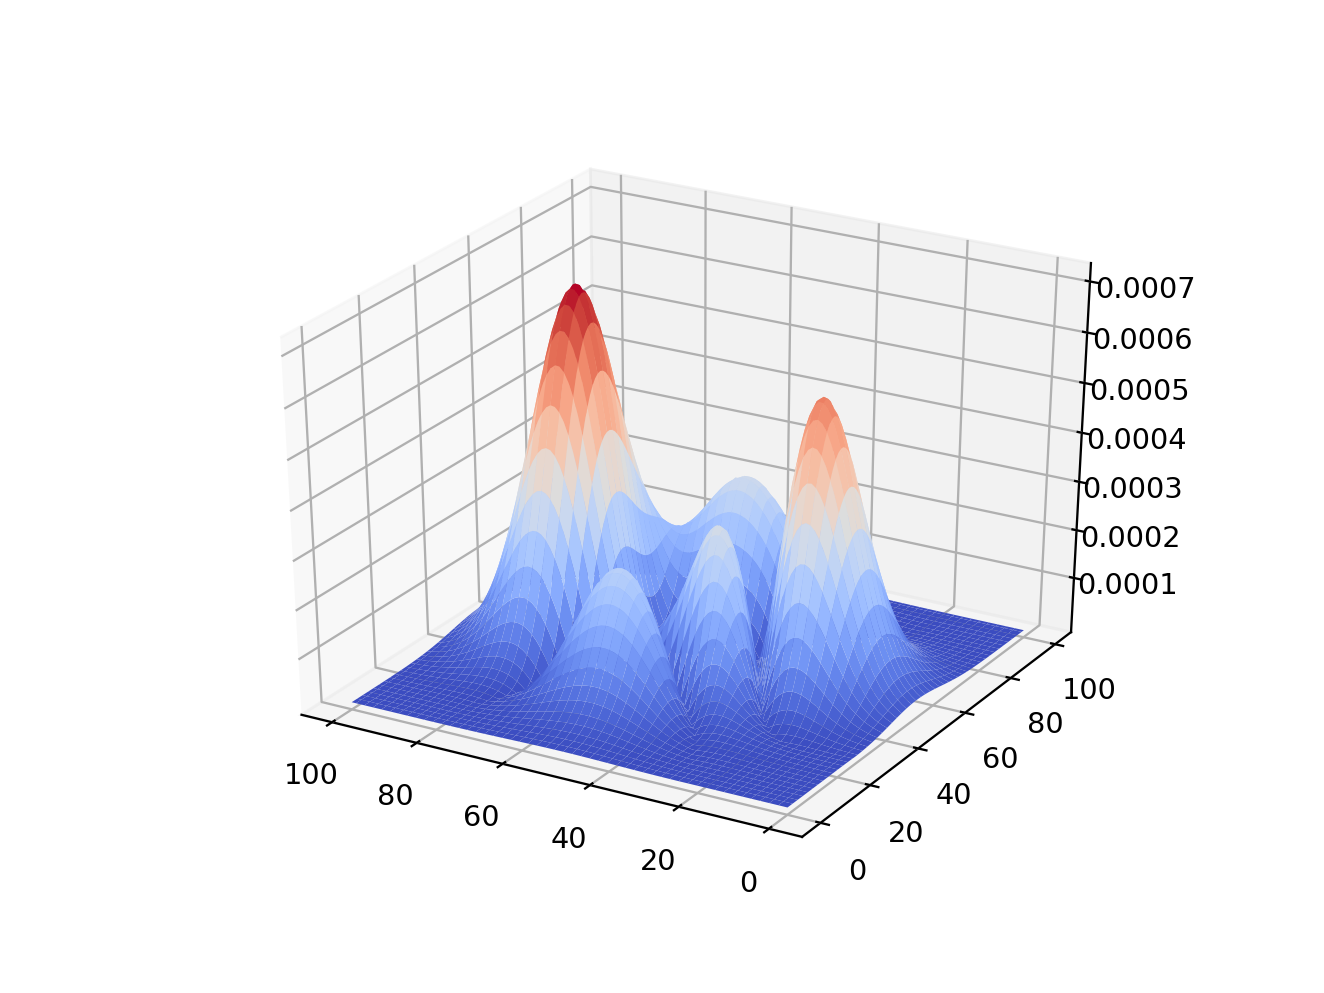

In [4]:
# Plot the 3D plot of pdf
# --------------------------

X = np.arange(0,100 + 100./(n-1), 100./(n-1))
Y = np.arange(0,100 + 100./(n-1), 100./(n-1))
fig0 = plt.figure()
ax = fig0.gca(projection='3d')
X, Y = np.meshgrid(X, Y)
surf = ax.plot_surface(Y, X, pdf,rstride=2, cstride=2, cmap=plt.cm.coolwarm, linewidth=0.1)
plt.gca().invert_xaxis()
plt.show()

**RANDOM WALK TAKING INTO ACCOUND THE LIMITATIONS IN THE NEIGHBORHOOD**


<IPython.core.display.Javascript object>


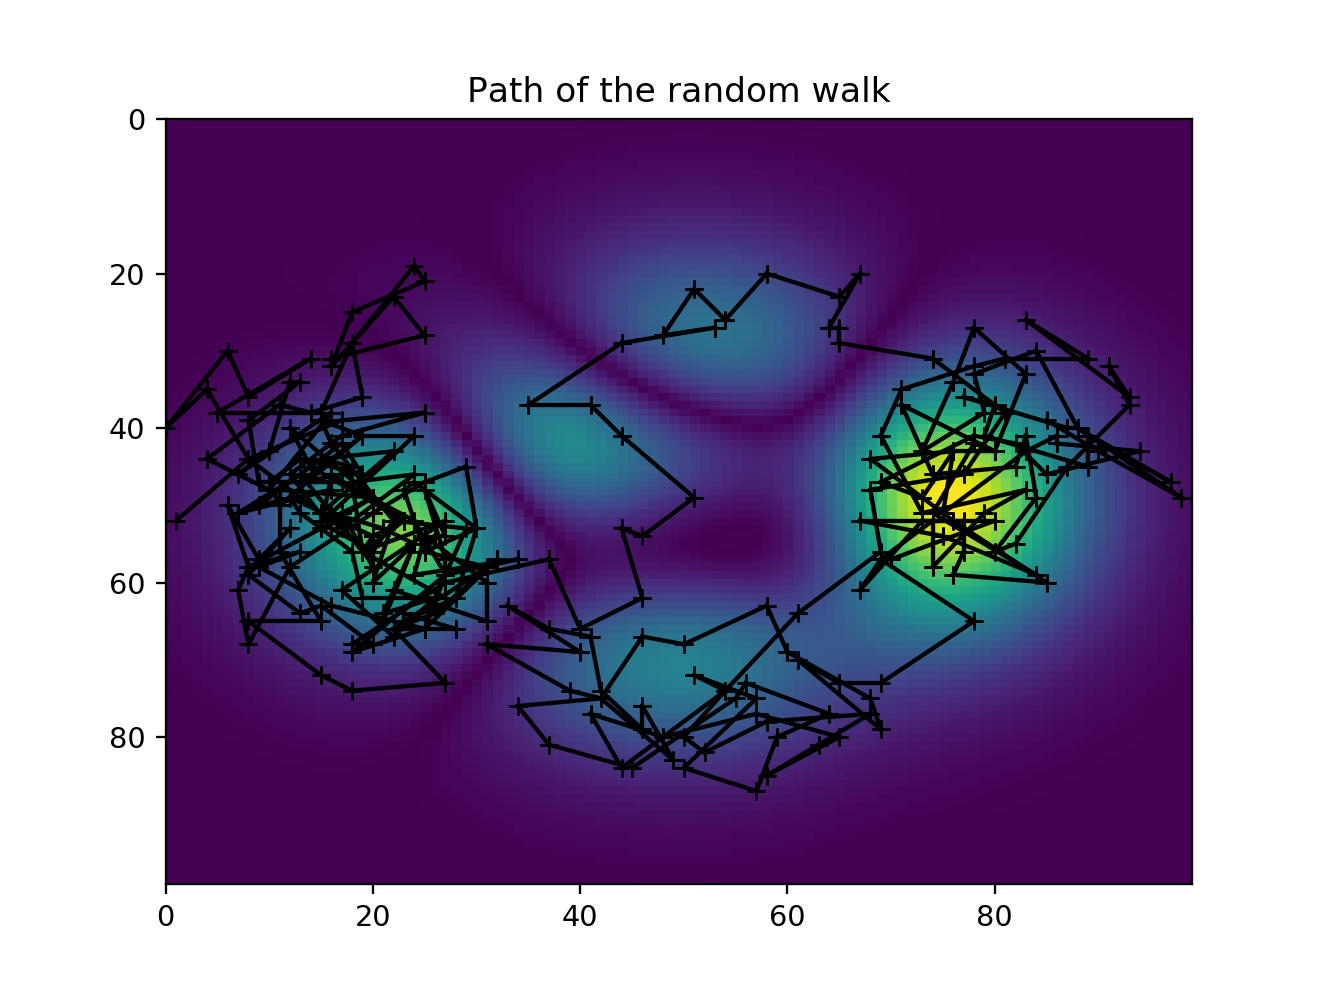

In [5]:
# Random walk and ploting the path

# find an initial vector x
xcur = np.array([np.floor(np.random.uniform(0, n)), np.floor(np.random.uniform(0, n))])

# Let s get moving
iis = 1
npp = 0
xa = np.zeros([ns+1,2])
xa[0,0] = xcur[0]
xa[0,1] = xcur[1]

## Ploting the path 
fig = plt.figure()
f1 = fig.add_subplot(111)  
f1.imshow(pdf.transpose(),aspect='auto',interpolation='none', animated=True)
f1.set_xlim(0,99)
f1.set_ylim(99,0)
f1.set_title('Path of the random walk')
plt.ion() #set interactive mode
plt.show()

Pa = np.zeros(ns+1)
xnew = np.array([0.,0.])

while iis <= ns:
    npp = npp+1;   
    #make a random choice for the next move
    xnew = xcur + 1
    
    for i in range(0,2):
        a = np.around((np.random.uniform(0, 1) - 0.5) * n * neigh) + xcur[i]
        if a <= 0:
            a = 0
        if a >= n:
            a = n-1
        xnew[i] = a

    #compare probabilities
    Pcur = pdf[int(xcur[0]), int(xcur[1])]
    Pnew = pdf[int(xnew[0]), int(xnew[1])]
   
    if Pnew >= Pcur:
        xcur = xnew
        xa[iis,0] = xcur[0]
        xa[iis,1] = xcur[1]
        Pa[iis] = Pnew
        ##print(' Made the %i-th move to [%i,%i] (Pnew>Pold) ' %(iis, xcur[0], xcur[1]))
        
        # display move graphically   
        f1.plot([xa[iis-1, 0], xa[iis,0]], [xa[iis-1, 1], xa[iis,1]],'k-')
        f1.plot([xa[iis-1, 0], xa[iis,0]], [xa[iis-1, 1], xa[iis,1]],'k+')
        plt.gcf().canvas.draw() #show the update
        iis = iis + 1
    
    if Pnew < Pcur: 
        P = Pnew / Pcur
        test = np.random.uniform(0,1)
        if test <= P: 
            xcur = xnew
            xa[iis,0] = xcur[0]
            xa[iis,1] = xcur[1]
            Pa[iis] = Pnew
            ##print( ' Made the %i-th move to [%i,%i] (Pnew<Pold) ' %(iis, xcur[0], xcur[1]) )
      
        # display move graphically

            f1.plot([xa[iis-1, 0], xa[iis,0]], [xa[iis-1, 1], xa[iis,1]],'k-')
            f1.plot([xa[iis-1, 0], xa[iis,0]], [xa[iis-1, 1], xa[iis,1]],'k+')
            plt.gcf().canvas.draw()  #show the update
            iis = iis + 1
plt.gcf().canvas.draw()

<IPython.core.display.Javascript object>


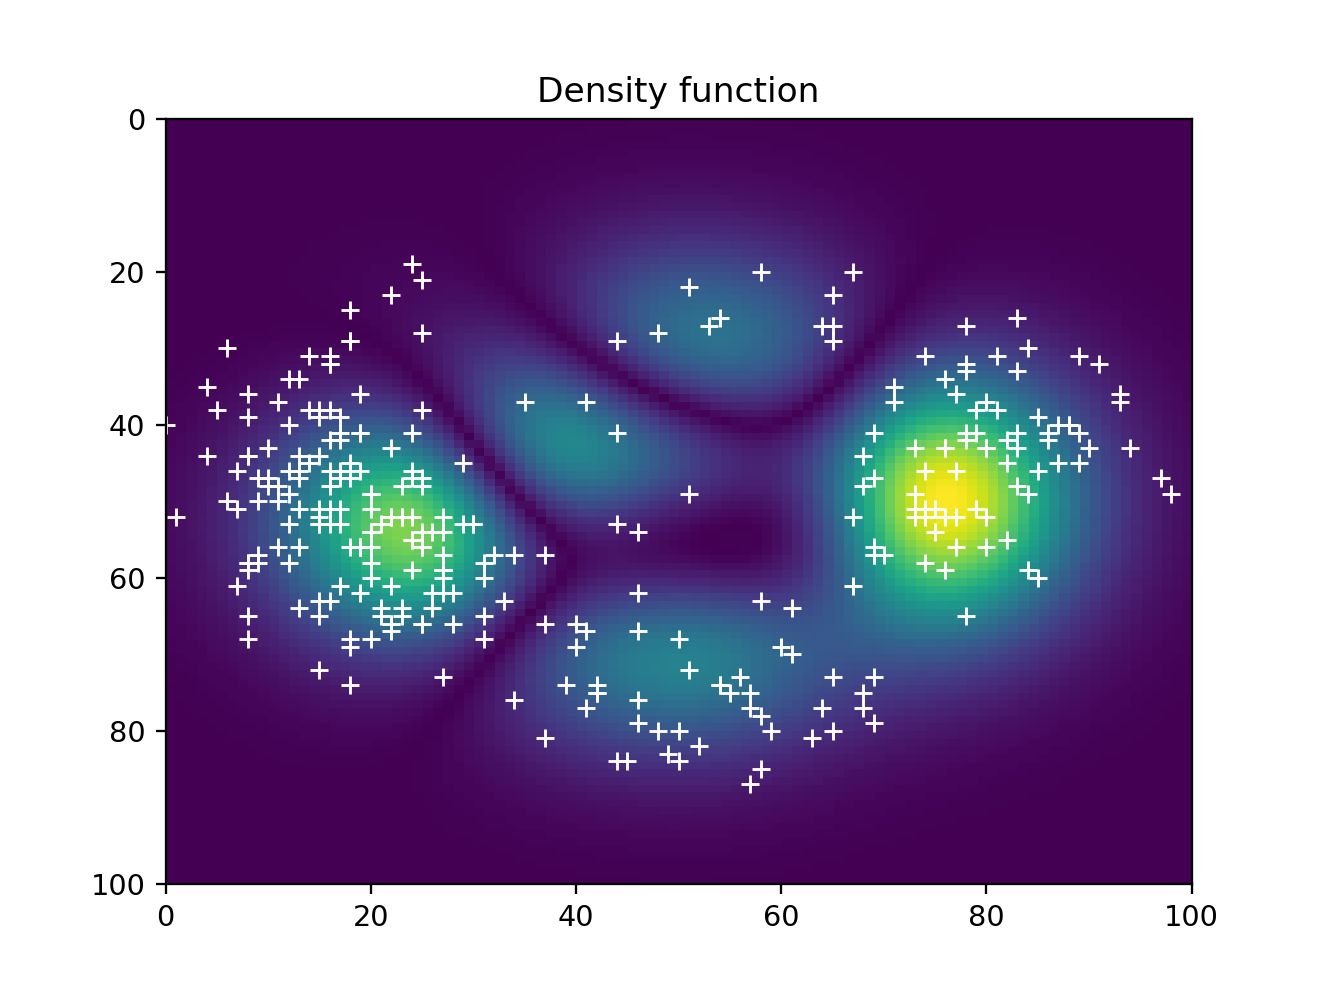

In [6]:
# Final sampling

fig = plt.figure()
plt.imshow(pdf.transpose(),aspect='auto', extent=[0,100,100,0],interpolation='none')
plt.plot(xa[:,0],xa[:,1],'w+')
plt.title('Density function')
plt.show()